# Exploratory Data Analysis 

We want to look at the relationship between Cognitive Function (Fine, MCI, AD) and the underlying Pathology (AD vs no AD). 

## Loading the Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from importlib import reload
import seaborn as sns
from tabulate import tabulate
import sidetable as stb
import os, sys

sys.path.append(os.path.join("../", "utils"))
import load_data

In [2]:
reload(load_data)
uds = load_data.load_uds()
mri = load_data.load_mri()
csf = load_data.load_csf()
csf = csf.drop(['CSFTTYR', 'CSFLPMO', 'CSFLPDY', 'CSFABMO', 'CSFABDY', 'CSFABYR',
                'CSFPTMO', 'CSFPTDY', 'CSFPTYR', 'CSFTTMO', 'CSFTTDY', 'CSFTTYR', 'CSFLPYR',
                'CSFTTMDX','CSFABMDX', 'CSFPTMDX'], axis=1)
uds_dict, mri_dict = load_data.load_feature_map()
print(uds.shape, mri.shape, csf.shape)

(45100, 94) (11273, 172) (3017, 8)


In [87]:
csf

,NACCADC,NACCID,CSFABETA,CSFPTAU,CSFTTAU,CSFABMD,CSFPTMD,CSFTTMD
0,2289,NACC265439,491.00,NaN,388.00,1,NaN,1.0
1,2289,NACC557124,614.40,38.60,32.20,2,2.0,2.0
2,2289,NACC413711,365.00,NaN,793.00,1,NaN,1.0
3,2289,NACC769575,274.00,NaN,255.00,1,NaN,1.0
4,2289,NACC773787,348.40,84.10,49.90,2,2.0,2.0
...,...,...,...,...,...,...,...,...
3012,2793,NACC023040,476.13,121.90,449.53,2,2.0,2.0
3013,2793,NACC074386,610.83,59.58,304.56,2,2.0,2.0
3014,2793,NACC216377,886.73,284.08,1317.00,2,2.0,2.0
3015,2793,NACC538380,427.43,116.80,457.12,2,2.0,2.0


#### Recode data so that we can easily see proportion of men vs women

In [57]:
def binary_sex(series):
    if series  == 1:
        return 0
    elif series == 2:
        return 1

uds['SEX_BIN'] = uds['SEX'].apply(binary_sex)
uds['SEX_BIN'].value_counts(sort=False)

0    19349
1    25751
Name: SEX_BIN, dtype: int64

In [58]:
uds['SEX'].value_counts(sort=False)

1    19349
2    25751
Name: SEX, dtype: int64

## EDA 

UDSD:
1 = Normal cognition 
2 = Impaired-not-MCI 
3 = MCI 
4 = Dementia


ALZP:
1 = Primary
2 = Contributing
3 = Non-contributing
7 = Cognitively impaired but not AD diagnosis
8 = Diagnosis of normal cognition

First look at demographics of cognitive impairment and responsible pathology


In [109]:
uds['NACCUDSD'] = pd.Categorical(uds.NACCUDSD)
uds['NACCALZP'] = pd.Categorical(uds.NACCALZP)
uds['UDSD_LAB'] = uds['NACCUDSD'].map({1: 'Normal cognition', 2: 'Impaired-not-MCI', 3: 'MCI', 4: 'Dementia'})

uds['ALZP_LAB'] = uds['NACCALZP'].map({ 1: 'Primary', 2: 'Contributing', 3: 'Non-contributing' ,
                                       7: 'Cognitively impaired - not AD', 8: 'Diagnosis of normal cognition'})

In [37]:
pd.crosstab( uds.NACCALZP, uds.NACCUDSD, 
            #rownames=['Primary', 'Contributing', 'Non-Cont', 'Not AD', 'Normal Cog','Total'], 
            #colnames=['Normal', 'Impaired not MCI', 'MCI', 'Dementia','Total'],
            margins=True)

NACCUDSD,1,2,3,4,All
NACCALZP,,,,,
1,0,332,4255,11288,15875
2,0,40,236,714,990
3,0,0,4,5,9
7,0,1621,5357,3476,10454
8,17772,0,0,0,17772
All,17772,1993,9852,15483,45100


In [45]:
pd.crosstab( uds.NACCALZP, uds.NACCUDSD, 
            #rownames=['Primary', 'Contributing', 'Non-Cont', 'Not AD', 'Normal Cog','Total'], 
            #colnames=['Normal', 'Impaired not MCI', 'MCI', 'Dementia','Total'],
            values = uds['NACCAGE'],
            aggfunc = 'mean',
            margins=True).round(2)

NACCUDSD,1,2,3,4,All
NACCALZP,,,,,
1,NaN,73.35,73.41,74.21,73.98
2,NaN,72.58,73.38,71.93,72.30
3,NaN,NaN,69.00,73.60,71.56
7,NaN,69.37,72.11,67.13,70.03
8,70.14,NaN,NaN,NaN,70.14
All,70.14,70.09,72.70,72.52,71.51


In [46]:
pd.crosstab( uds.NACCALZP, uds.NACCUDSD, 
            #rownames=['Primary', 'Contributing', 'Non-Cont', 'Not AD', 'Normal Cog','Total'], 
            #colnames=['Normal', 'Impaired not MCI', 'MCI', 'Dementia','Total'],
            values = uds['EDUC'],
            aggfunc = 'mean',
            margins=True).round(2)

NACCUDSD,1,2,3,4,All
NACCALZP,,,,,
1,NaN,16.07,15.60,14.18,14.60
2,NaN,14.65,14.96,14.61,14.70
3,NaN,NaN,16.50,17.50,17.00
7,NaN,14.48,14.91,15.06,14.89
8,15.79,NaN,NaN,NaN,15.79
All,15.79,14.75,15.21,14.39,15.14


In [60]:
pd.crosstab( uds.NACCALZP, uds.NACCUDSD, 
            #rownames=['Primary', 'Contributing', 'Non-Cont', 'Not AD', 'Normal Cog','Total'], 
            #colnames=['Normal', 'Impaired not MCI', 'MCI', 'Dementia','Total'],
            values = uds['SEX_BIN'],
            aggfunc = 'mean',
            margins=True).round(2)

NACCUDSD,1,2,3,4,All
NACCALZP,,,,,
1,NaN,0.55,0.50,0.56,0.55
2,NaN,0.48,0.51,0.44,0.46
3,NaN,NaN,0.50,0.20,0.33
7,NaN,0.58,0.50,0.40,0.48
8,0.65,NaN,NaN,NaN,0.65
All,0.65,0.58,0.50,0.52,0.57


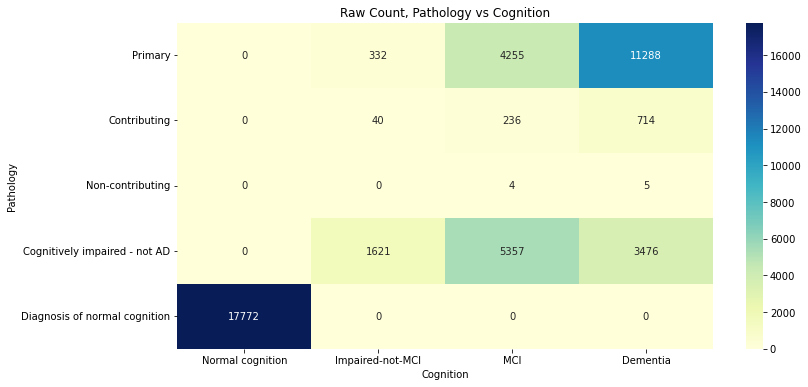

In [145]:
plt.figure(figsize=(12, 6))
sns.heatmap(
    pd.crosstab( uds.ALZP_LAB, uds.UDSD_LAB, 
            colnames=['Cognition'], 
            rownames=['Pathology']),
    annot = True,
    cmap="YlGnBu",
    fmt='d'
)
plt.title("Raw Count, Pathology vs Cognition")
plt.savefig("count_by_UDSD_ALZP", bbox_inches='tight')
plt.show()

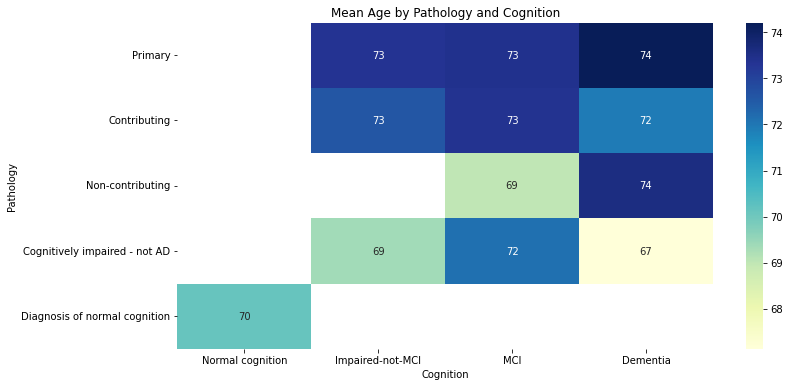

In [126]:
plt.figure(figsize=(12, 6))
sns.heatmap(
    pd.crosstab( uds.ALZP_LAB, uds.UDSD_LAB, 
            colnames=['Cognition'], 
            rownames=['Pathology'],
            values = uds['NACCAGE'],
            aggfunc = 'mean',
            margins=False,
            margins_name="Total").round(2), 
    annot = True,
    cmap="YlGnBu"
)
plt.title("Mean Age by Pathology and Cognition")
plt.savefig("age_by_UDSD_ALZP", bbox_inches='tight')
plt.show()

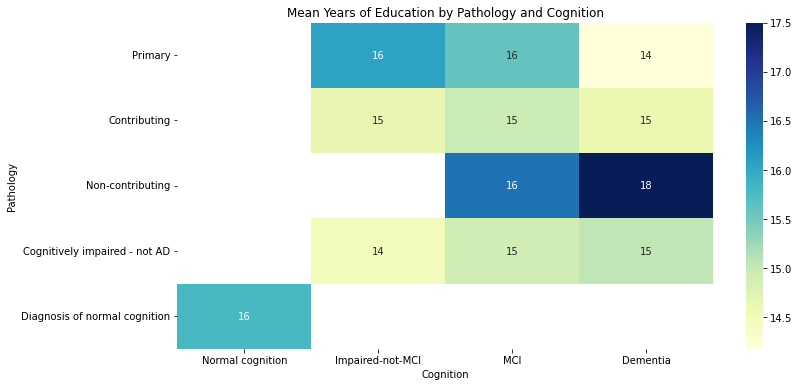

In [127]:
plt.figure(figsize=(12, 6))
sns.heatmap(
    pd.crosstab( uds.ALZP_LAB, uds.UDSD_LAB, 
            colnames=['Cognition'], 
            rownames=['Pathology'],
            values = uds['EDUC'],
            aggfunc = 'mean',
            margins=False,
            margins_name="Total").round(2), 
    cmap="YlGnBu",
    annot = True
)
plt.title("Mean Years of Education by Pathology and Cognition")
plt.savefig("educ_by_UDSD_ALZP", bbox_inches='tight')
plt.show()

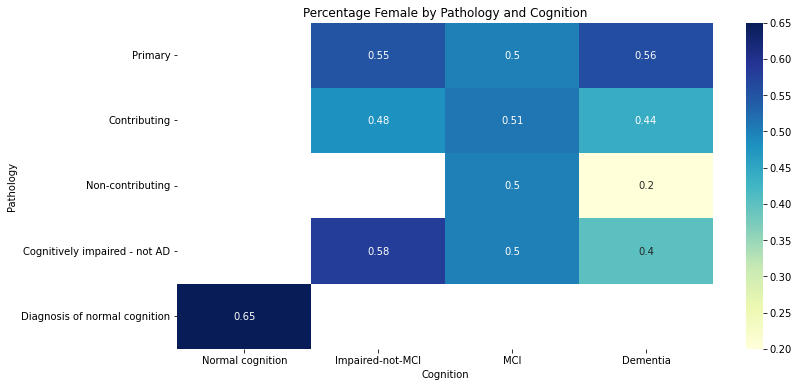

In [124]:
plt.figure(figsize=(12, 6))
sns.heatmap(
    pd.crosstab( uds.ALZP_LAB, uds.UDSD_LAB, 
            colnames=['Cognition'], 
            rownames=['Pathology'],
            values = uds['SEX_BIN'],
            aggfunc = 'mean',
            margins=False,
            margins_name="Total").round(2), 
    annot = True,
    cmap="YlGnBu"
)
plt.title("Percentage Female by Pathology and Cognition")
plt.savefig("female_by_UDSD_ALZP", bbox_inches='tight')
plt.show()

In [85]:
mri.groupby('NACCID')['MRIMO'].count()

NACCID
NACC000034    1
NACC000225    2
NACC000511    1
NACC000531    2
NACC000540    1
             ..
NACC999546    2
NACC999566    2
NACC999724    1
NACC999780    1
NACC999854    3
Name: MRIMO, Length: 7328, dtype: int64

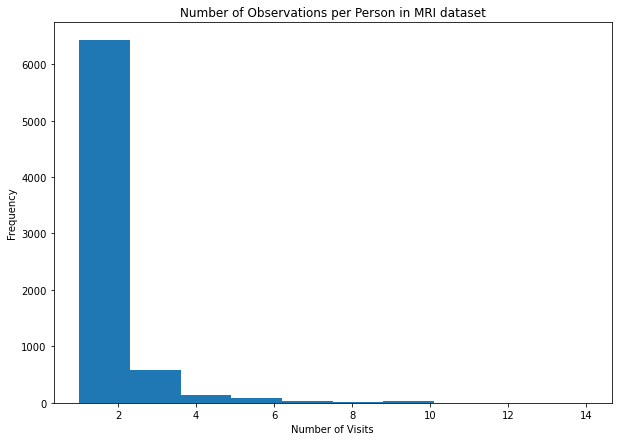

In [97]:
# Creating histogram
fig, axs = plt.subplots(figsize =(10, 7))
 
axs.hist(mri.groupby('NACCID')['MRIMO'].count())

plt.title('Number of Observations per Person in MRI dataset')
plt.xlabel('Number of Visits')
plt.ylabel('Frequency')
plt.savefig('mri_obs_per_person.png')
# Show plot
plt.show()


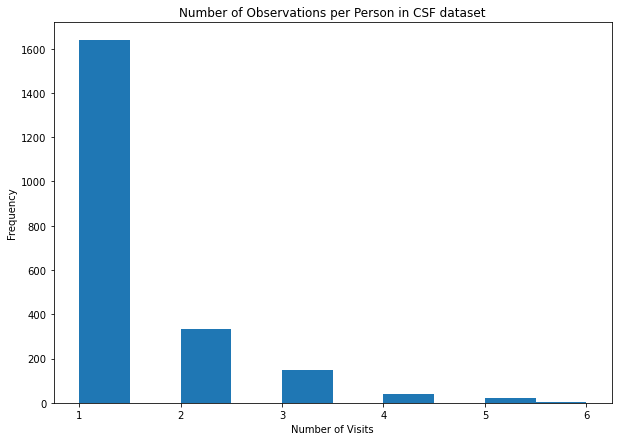

In [98]:
# Creating histogram
fig, axs = plt.subplots(figsize =(10, 7))
 
axs.hist(csf.groupby('NACCID')['NACCADC'].count())
plt.title('Number of Observations per Person in CSF dataset') 
plt.xlabel('Number of Visits')
plt.ylabel('Frequency')
plt.savefig('csf_obs_per_person.png')
# Show plot
plt.show()

## Relationship within missing values 

In [128]:
pd.options.display.max_rows = 999 
uds.stb.missing()

,missing,total,percent
ELATSEV,43620,45100,96.718404
HALLSEV,43170,45100,95.720621
DELSEV,41895,45100,92.893570
MOTSEV,40294,45100,89.343681
DISNSEV,39664,45100,87.946785
APPSEV,37750,45100,83.702882
AGITSEV,36709,45100,81.394678
NITESEV,35806,45100,79.392461
APASEV,34994,45100,77.592018
ANXSEV,34311,45100,76.077605


In [135]:
#want a proportion of missing values for each person excluding demographics/ visit number etc. 
uds['NUM_MIS_ROW'] = uds.isnull().sum(axis=1)/91
mri['NUM_MIS_ROW'] = mri.isnull().sum(axis=1)/167
csf['NUM_MIS_ROW'] = csf.isnull().sum(axis=1)/6 

In [ ]:
# Creating histogram
fig, axs = plt.subplots(figsize =(10, 7))
 
axs.hist(uds['NUM_MIS_ROW'])

plt.title('Proportion of Missing Values Per Person')
plt.xlabel('Proportion of Missing Values')
plt.ylabel('Frequency')
#plt.savefig('uds

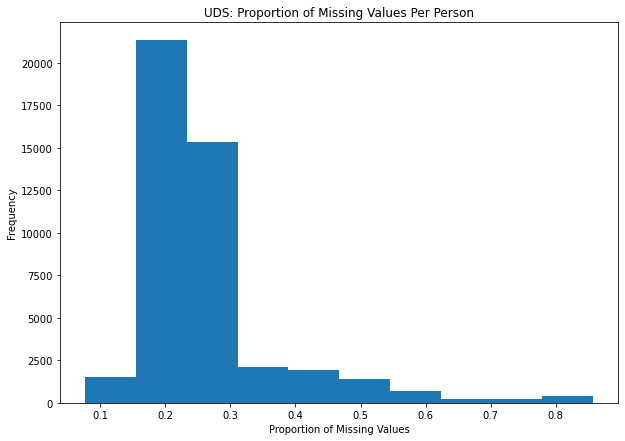

In [141]:
# Creating histogram
fig, axs = plt.subplots(figsize =(10, 7))
 
axs.hist(uds['NUM_MIS_ROW'])

plt.title('UDS: Proportion of Missing Values Per Person')
plt.xlabel('Proportion of Missing Values')
plt.ylabel('Frequency')
plt.savefig('uds_missing_per_person.png')
# Show plot
plt.show()

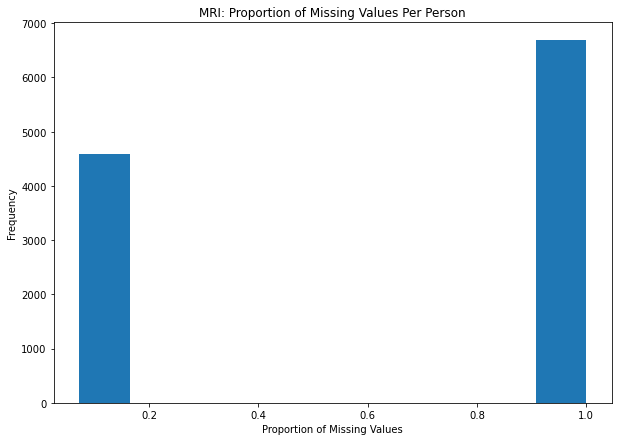

In [138]:
# Creating histogram
fig, axs = plt.subplots(figsize =(10, 7))
 
axs.hist(mri['NUM_MIS_ROW'])

plt.title('MRI: Proportion of Missing Values Per Person')
plt.xlabel('Proportion of Missing Values')
plt.ylabel('Frequency')
plt.savefig('mri_missing_per_person.png')
# Show plot
plt.show()

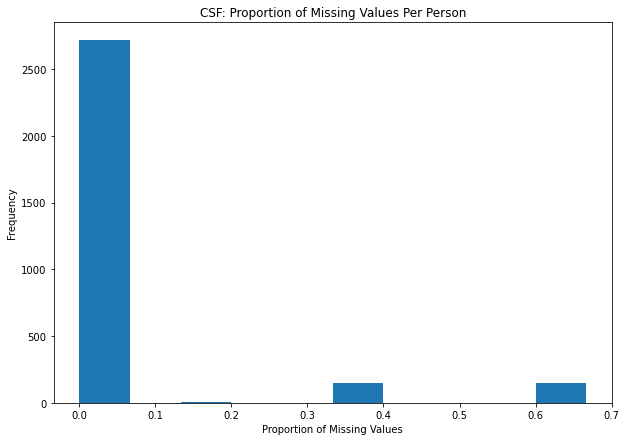

In [140]:
# Creating histogram
fig, axs = plt.subplots(figsize =(10, 7))
 
axs.hist(csf['NUM_MIS_ROW'])

plt.title('CSF: Proportion of Missing Values Per Person')
plt.xlabel('Proportion of Missing Values')
plt.ylabel('Frequency')
plt.savefig('csf_missing_per_person.png')
# Show plot
plt.show()

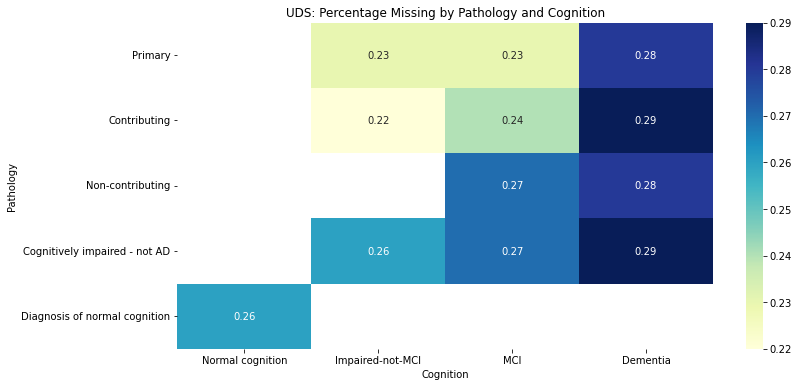

In [142]:
plt.figure(figsize=(12, 6))
sns.heatmap(
    pd.crosstab( uds.ALZP_LAB, uds.UDSD_LAB, 
            colnames=['Cognition'], 
            rownames=['Pathology'],
            values = uds['NUM_MIS_ROW'],
            aggfunc = 'mean',
            margins=False,
            margins_name="Total").round(2), 
    annot = True,
    cmap="YlGnBu"
)
plt.title("UDS: Percentage Missing by Pathology and Cognition")
plt.savefig("missing_uds_by_UDSD_ALZP", bbox_inches='tight')
plt.show()